In [46]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [47]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from rag.pdf import PDFRetrievalChain
from langchain_teddynote.tools.tavily import TavilySearch

from typing import List, Literal
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.documents import Document

In [48]:
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

In [49]:
state = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    documents = []
)

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [50]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### PDF 기반 문서 검색기 (Retrieval chain) : 사용자 질문에 대한 PDF 문서를 검색

In [51]:
# 문서 검색 노드
def retrieve(state: GraphState):
    
    question = state['question']                    # 사용자 질문
    
    documents = pdf_retriever.invoke(question)      # 문서 검색 (pdf_retriever 에 사용자 입력을 인자로 넣어서 문서를 검색)
    
    return {'documents': documents}

In [52]:
answer = retrieve(state)

In [53]:
state['documents'] = answer['documents']

In [54]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

### 답변 생성을 위한 RAG 체인

In [55]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

In [56]:
# RAG 체인에 질문을 전달하여 답변 생성 테스트
print(f"question: {state['question']}")
print(f"format_docs(docs): {format_docs(state['documents'])}")

question: 삼성전자가 만든 생성형 AI 이름은?
format_docs(docs): <document><content>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>2</page></document>

<document><content>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></document>

<document><content>£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델
‘삼성 가우스’를 최초 공개
∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스

In [57]:
generation = rag_chain.invoke({'context': format_docs(state['documents']), 'question': state['question']})
generation

"삼성전자가 만든 생성형 AI의 이름은 '삼성 가우스'입니다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)"

### 답변 생성을 위한 RAG 체인을 실행하여 사용자 질문에 대한 답변을 생성하는 노드

In [58]:
# 답변 생성 노드
def generate(state: GraphState):

    question = state['question']            # 사용자 질문
    
    documents = state['documents']          # 문서 검색 결과

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    return {'generation': generation}

In [59]:
state['generation'] = generate(state)['generation']

In [60]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동 가능하여 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 공개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadat

### 문서 검색 평가기 (Retrieval Grader)

In [61]:
class GradeDocuments(BaseModel):        # 문서 평가를 위한 데이터 모델
    """Binary score for relevance check on retrieved documents."""

    # 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색 평가기(retrieval_grader)를 사용해서 
    # 사용자 질문과 검색 결과문서가 관련성이 있는지 본다

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기
retrieval_grader = grade_prompt | structured_llm_grader

In [62]:
filtered_docs = []                                    # 문서 검색 평가기를 통과한 문서들만 필터링

for doc in state['documents']:
    result = retrieval_grader.invoke({'question': state['question'], 'document': doc.page_content})
    print(f"result.binary_score: {result.binary_score}")
    
    if result.binary_score == 'yes':
        filtered_docs.append(doc)

result.binary_score: yes
result.binary_score: yes
result.binary_score: yes
result.binary_score: yes
result.binary_score: no
result.binary_score: yes
result.binary_score: yes
result.binary_score: no
result.binary_score: no
result.binary_score: no


### 사용자 질문에 대한 pdf 문서 검색 결과의 관련성을 평가하는 문서 검색 평가기(retrieval_grader) 노드

In [63]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score

        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)                   
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     

    return {'documents': filtered_docs}

In [64]:
return_documents = grade_documents(state)

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


In [65]:
state['documents'] = return_documents['documents']
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동 가능하여 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 공개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadat

### 쿼리 재작성 (Query Rewriter)

In [66]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

In [67]:
question_rewriter.invoke({'question': state['question']})

'삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?'

### Query Rewrite 노드

In [68]:
# Query Rewrite 노드
def transform_query(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 쿼리 재작성 노드 🔄')

    # 사용자 질문
    question = state['question']

    # 문서 검색 결과
    documents = state['documents']

    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    
    print('-------------------')
    print(f"better_question: {better_question}")
    print('-------------------')
    
    print('==========================================================================================\n')

    return {'question': better_question}

In [69]:
question_rewriter_return = transform_query(state)
state['question'] = question_rewriter_return['question']


🔄 [Node] 쿼리 재작성 노드 🔄
-------------------
better_question: 삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?
-------------------



In [70]:
state

{'question': '삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동 가능하여 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 공개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3',

### 웹 검색 도구

In [71]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)

In [72]:
# 웹 검색 도구 호출
result = web_search_tool.search('대구 고깃집에 대해서 알려주세요')
result

[{'title': "'대구 고깃집' 맛집 빅데이터 추천순위 Top100 - 다이닝코드",
  'url': 'https://www.diningcode.com/list.dc?query=대구++고깃집',
  'content': '3. 육즙 대구 --------- 73점 5.0 (2명) 영업 중 삼겹살 회식,주차,예약,콜키지  "직접 고기를 구워주시니 편했고 고기도 맛있는데 밑반찬이 진리입니댜" 6. 고기굽는남자 본점 ------------- 72점 4.5 (12명) 영업 중 삼겹살 술모임,무료주차,시끌벅적한,단체석  "제 최애 고깃집이에요" 9. 은하수식당 삼덕동 ------------- 72점 4.9 (6명) 영업 중 삼겹살 술모임,주차,서민적인  "대구 삼덕동에 위치한 고깃집입니다." 83해치 복현점 ------------- 69점 5.0 (2명) 영업 중 삼겹살 회식,예약,예약가능  "복현동 먹자골목 고기 맛집, 직원들 텐션이 어마무시한 고깃집 😲 고기도 다 구워주고 편하게 먹기 좋은곳 매장도 넓어서 회식하기 좋을듯!" 혜옥당 대구 ----------- 69점 4.9 (7명) 영업 중 삼겹살 술모임,캐주얼한  "프라이빗한 느낌을 줘서 일반 고깃집보다 편안하게 즐길 수 있다 너무 시끌벅적한 느낌이 아니라 편안..레트로 인테리어가 정감있었던 구워주는 고깃집 맛있게 구워주셔서 좋은데 비계가 정말 많아서 마지막엔 살짝 느끼했다 그럴때 냉메밀면 먹으면 내려감" 고기굽는남자 신세계점 ---------------- 69점 4.5 (11명) 영업 중 삼겹살 식사모임,무료주차,시끌벅적한,놀이방  "오랜만에 방문했는데 역시 맛있어요!!!',
  'score': 0.72814995,
  'raw_content': '\'대구 고깃집\' 맛집 빅데이터 추천순위 Top100 - 다이닝코드\n\n\n\n이용자층\n카테고리방문목적편의기능분위기인증맛집\n\n20대\n30대\n40대\n50대\n60대 이상\n\n\n\n여성\n\n남성\n\n\n연관순\n\n평점순\n리뷰많은순\n좋아요많은순\

### 웹 검색 노드

In [73]:
# 웹 검색 노드
def web_search(state):

    question = state['question']    # 사용자 질문

    web_results = web_search_tool.invoke({"query": question})   # 웹 검색 수행

    web_results_docs = []
    
    for result in web_results:
        doc = Document(
            page_content=result["content"],
            metadata={"source": result["url"]}
        )
        web_results_docs.append(doc)
        

    return {"documents": web_results_docs}

In [74]:
web_search(state)

{'documents': [Document(metadata={'source': 'https://www.fnnews.com/news/202309031940191378'}, page_content='삼성전자 생성형 AI 이름은 \'삼성 가우스\' \'가이스\' - 파이낸셜뉴스 삼성전자 생성형 AI 이름은 \'삼성 가우스\' \'가이스\' 삼성전자가 자체 생성형 인공지능(AI) 서비스 상표권을 출원하며 연내 상용화를 위해 속도를 내고 있다. 전경훈 삼성전자 DX부문 최고기술책임자(CTO) 겸 삼성리서치장(사장)은 최근 사내 타운홀 미팅에서 자체 생성형 AI 개발 방향성을 코딩 지원, 문서 요약, 이메일 전송 등 사내 생산성 향상과 삼성 디바이스 탑재 등 두 가지로 설명한 바 있다. 가출 후 2주 만에 실종된 남편, 숨진 채 발견 [속보]김현태 707단장 "곽종근 자수서에 \'국회의원\' \'끌어내라\' 단어 없다" [속보]김현태 707단장 "尹지시가 단전 배경이란 건 내용 안 맞아" 현대차 크레타 EV, 인도서 돌풍…2주 만에 1700대 판매 가출 후 2주 만에 실종된 남편, 숨진 채 발견 "청소 아줌마, 당 떨어진다며 3만원 양갱 몰래 먹어…따지니 \'엄마뻘한테?\'" [어떻게 생각하세요] "9개월 만에 20kg 감량" 20대 여성이 밝힌 놀라운 비법은'),
  Document(metadata={'source': 'https://www.fnnews.com/news/202309031940191378'}, page_content='삼성전자 생성형 AI 이름은 \'삼성 가우스\' \'가이스\' - 파이낸셜뉴스 삼성전자 생성형 AI 이름은 \'삼성 가우스\' \'가이스\' 삼성전자가 자체 생성형 인공지능(AI) 서비스 상표권을 출원하며 연내 상용화를 위해 속도를 내고 있다. 전경훈 삼성전자 DX부문 최고기술책임자(CTO) 겸 삼성리서치장(사장)은 최근 사내 타운홀 미팅에서 자체 생성형 AI 개발 방향성을 코딩 지원, 문서 요약, 이메일 전송 등 사내 생산성 향상과 삼성 

### 질문 라우팅 노드

In [75]:
class RouteQuery(BaseModel):    
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# 구조화된 출력을 결과로 가젼온다 (vectorstore, web_search)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# 프롬프트
route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', '{question}')
    ]
)

question_router = route_prompt | structured_llm_router

In [76]:
# 쿼리 라우팅 테스트 (문서 검색이 필요한 질문)
result = question_router.invoke({'question': 'AI Brief 에서 삼성전자가 만든 생성형 AI 이름은?'})
result

RouteQuery(datasource='vectorstore')

In [77]:
# 쿼리 라우팅 테스트 (웹 검색이 필요한)
result = question_router.invoke({'question': '대구 중앙떡볶이에 대해서 알려줘.'})
result

RouteQuery(datasource='web_search')

### 질문 라우팅 노드

In [78]:
# 질문 라우팅 노드
def route_question(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 질문 라우팅 노드 🔄')

    # 사용자 질문
    question = state['question']

    # 질문 라우팅
    source = question_router.invoke({'question': question})

    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        print('==========================================================================================\n')
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        print('==========================================================================================\n')
        return "vectorstore"

In [79]:
route_question(state)


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO VECTORSTORE] ====



'vectorstore'

### 문서 관련성 평가 노드

In [80]:
# 문서 관련성 평가 노드
def decide_to_generate(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 문서 관련성 평가 노드 🔄')

    # 문서 검색 결과 가져오기
    filtered_documents = state['documents']

    if not filtered_documents:                              # 문서가 없는 경우 (모든 문서가 관련성 없는 문서)
        print(f'===== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] =====')
        print('==========================================================================================\n')
        return "transform_query"        
    else:                                                   # 관련성 있는 문서가 있는 경우
        print(f"===== [DECISION: GENERATE] =====")
        print('==========================================================================================\n')
        return "generate"

In [81]:
decide_to_generate(state)


🔄 [Node] 문서 관련성 평가 노드 🔄
===== [DECISION: GENERATE] =====



'generate'

# 답변에 대한 Hallucination checker 추가

In [82]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# system
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
) 

# hallucination 평가기 생성
hallucination_grader = hallucination_prompt | structured_hallucination_grader

In [83]:
# hallucination 평가기 테스트 (생성된 답변과 질문에 대한 평가)
hallucination_grader.invoke({"documents": format_docs(state['documents']), "generation": generation})

GradeHallucinations(binary_score='yes')

In [84]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# system
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 템플릿
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

In [85]:
answer_grader.invoke({'question': state['question'], 'generation': generation})

GradeAnswer(binary_score='yes')

### hallucination_check

In [86]:
# Hallucination 평가 노드
def hallucination_check(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] hallucination 평가 노드 🔄')

    # 사용자 질문
    qestion = state['question']

    # 문서 검색 결과
    documents = state['documents']

    # 생성된 답변
    generation = state['generation']

    # 평가
    score = hallucination_grader.invoke({'documents': documents, 'generation': generation})
    grade = score.binary_score

    print(f"===== [평가 결과] =====")
    print(grade)

    if grade == 'yes':     # hallucination 없음
        print("===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====")
        print("no hallucination")

        # 답변에 대한 관련성 평가
        print("===== [GRADE GENERATED ANSWER vs QUESTION] =====")

        score = answer_grader.invoke({'question': state['question'], 'generation': generation})
        grade = score.binary_score

        if grade == 'yes':          # 관련성 있는 답변
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            print("relevant")
            print('==========================================================================================\n')
            return "relevant"
        else:                       # 관련성 없는 답변
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            print("not relevant")
            print('==========================================================================================\n')
            return "not relevant"

    else:                   # hallucination 있음
        print("===== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] =====")
        print("hallucination")
        print('==========================================================================================\n')
        return "hallucination"

In [87]:
hallucination_check(state)


🔄 [Node] hallucination 평가 노드 🔄
===== [평가 결과] =====
yes
===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====
no hallucination
===== [GRADE GENERATED ANSWER vs QUESTION] =====
==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
relevant



'relevant'

# 테스트

In [88]:
state1 = GraphState(
    question='대구 중앙떡볶이',
    generation = '', 
    documents = []
)

state1

{'question': '대구 중앙떡볶이', 'generation': '', 'documents': []}

In [89]:
route_question(state1)


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO WEB SEARCH] ====



'web_search'

In [90]:
web_search(state1)

{'documents': [Document(metadata={'source': 'https://dtrip.salaitdaknit.com/entry/jungguk'}, page_content='대구 동성로는 늘 활기가 넘치는 곳이죠. 그중에서도 중앙떡볶이는 매콤달콤한 떡볶이와 대구의 명물 납작만두로 대구를 방문한 사람이라면 한 번쯤 꼭 들러야 할 맛집으로 꼽힙니다. 이번에 방문한 후기를 생생하게 전해드릴게요.중앙떡볶이 정보주소대구 중구 동성로2길 81 (중앙떡볶이)영업'),
  Document(metadata={'source': 'https://m.blog.naver.com/tb06081/223042140850'}, page_content='대구 동성로 228공원 앞에 위치한 대구 동성로 떡볶이 맛집 중앙떡볶이 예전부터 대구 떡볶이 맛집으로 유명했는데 떡볶이를 별로 안 좋아해서 몇년 전에 딱 한 번 먹어봤는데 그렇게 맛있단 생각을 못 해서 계속 안 가고 있다가 지금까지도 쭉 지나가면 항상 웨이팅 있거나 사람 많고 여전히 북적'),
  Document(metadata={'source': 'https://m.blog.naver.com/ryu8145/223424913321'}, page_content='대구 맛집 리뷰하는 블로거 루피입니다 오늘은 대구 떡볶이 하면 떠오르는곳 백종원 3대천왕 중앙떡볶이를 소개할께요')]}

In [91]:
state2 = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    documents = []
)

state2

{'question': '삼성전자가 만든 생성형 AI 이름은?', 'generation': '', 'documents': []}

In [92]:
route_question(state2)


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO VECTORSTORE] ====



'vectorstore'

In [93]:
answer = retrieve(state2)                        # 사용자 질문에 대해서 관련 문서를 검색한다.
state2['documents'] = answer['documents']

In [94]:
state2

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [95]:
state2['documents'] = grade_documents(state2)['documents']

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


In [96]:
state2

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [97]:
state2

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [98]:
state2['documents'] = grade_documents(state2)['documents']

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---


In [99]:
state2

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [100]:
state2['generation'] = generate(state2)['generation']

In [101]:
state2

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동하도록 설계되어 사용자 정보 유출 위험이 없습니다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 공개되었습니다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', 

In [102]:
hallucination_check(state2)


🔄 [Node] hallucination 평가 노드 🔄
===== [평가 결과] =====
yes
===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====
no hallucination
===== [GRADE GENERATED ANSWER vs QUESTION] =====
==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
relevant



'relevant'

In [103]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [104]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [105]:
######### 2. 노드 정의  #########

workflow.add_node('web_search', web_search)                 # 웹 검색  
workflow.add_node('retrieve', retrieve)                     # 문서 검색 노드
workflow.add_node('grade_documents', grade_documents)       # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
workflow.add_node('generate', generate)                     # 사용자 질문과 문서 검색결과를 가지고 답변 생성하는 노드
workflow.add_node('transform_query', transform_query)       # 사용자 질문(쿼리)를 재작성하는 노드

In [106]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_conditional_edges(
    START, 
    route_question,                     # 질문 라우팅 노드  
    {
        'web_search': 'web_search',     # 웹 검색으로 라우팅
        'vectorstore': 'retrieve'       # retrieve (PDF 문서 검색)로 라우팅
    }
)

In [107]:
workflow.add_edge('web_search', 'generate')         # 웹 검색하고 답변 생성
workflow.add_edge('retrieve', 'grade_documents')    # retrieve 노드에서 PDF 문서 검색실행 하고 결과를 문서 검색 평가기로 가서 평가

In [108]:
workflow.add_conditional_edges(
    'grade_documents',                              # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
    decide_to_generate,                             # 문서 관련성 평가
    {
        'transform_query': 'transform_query',       # 사용자 입력 다시 작성 필요
        'generate': 'generate'                      # 답변 생성
    }
)

In [109]:
workflow.add_edge('transform_query', 'retrieve')    # 쿼리 다시 작성한 뒤 문서 검색

In [110]:
workflow.add_conditional_edges(
    'generate',
    hallucination_check,
    {
        'hallucination': 'generate',                # Hallucination 발생 시 재생성
        'relevant': END,                            # 답변 관련성 통과     
        'not relevant': 'transform_query'           # 딥변 관련성 통과 못하는 경우. 쿼리 다시 작성
    }
)

In [111]:
######### 4. 체크 포인터 설정  #########

memory = MemorySaver()

In [112]:
######### 5. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

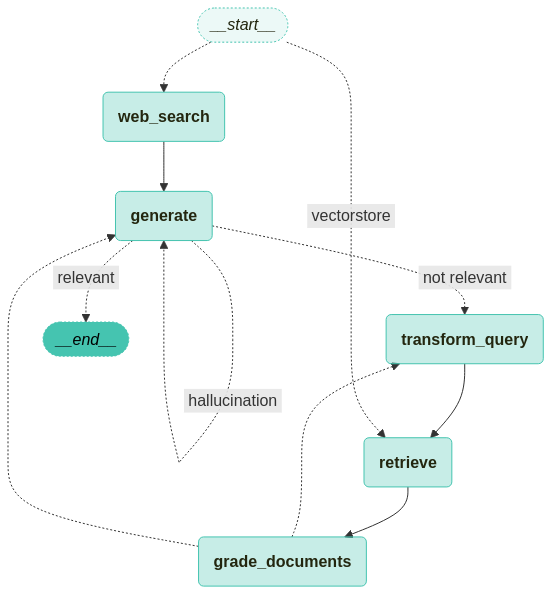

In [113]:
visualize_graph(app)

In [114]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [115]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 개발한 생성형 AI 이름은?')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO VECTORSTORE] ====

[node_name]: retrieve
[node_chunk]:
 {'documents': [Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, '

In [119]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO WEB SEARCH] ====

[node_name]: web_search
[node_chunk]:
 {'documents': [Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://m.blog.naver.com/sh_baekwoon/223359878100'}, page_content='대구 교보문고 대구점 방문 후기 : 네이버 블로그 대구 교보문고 대구점 방문 후기 며칠 전 동성로에 다녀오면서 교보문고 대구점도 방문하게 되어서 방문 후기도 포스팅! 대구에는 교보문고 대구점, 교보문고 칠곡점 이렇게 두 군데가 있어요~ 칠곡점은 아직 가보지 못했고 교보문고 대구점은 아이들과 책 구매를 위해 한 번씩 방문해요~ 아이들 키우는 부모들은 책 읽는 게 중요하다고 아이들에게 말하지만 실상은 그 부모들

In [120]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO WEB SEARCH] ====

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : web_search
state_value: 
 {'documents': [Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://m.blog.naver.com/sh_baekwoon/223359878100'}, page_content='대구 교보문고 대구점 방문 후기 : 네이버 블로그 대구 교보문고 대구점 방문 후기 며칠 전 동성로에 다녀오면서 교보문고 대구점도 방문하게 되어서 방문 후기도 포스팅! 대구에는 교보문고 대구점, 교보문고 칠곡점 이렇게 두 군데가 있어요~ 칠곡점은 아직 가보지 못했고 교보문고 대구점은 아이들과 책 구매를 위해 한 번씩 방문해요~ 아이들 키우는

In [122]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')


i = 1

for event in app.stream(inputs, config=config, stream_mode="updates"):

    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in event.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
            
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO VECTORSTORE] ====

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
------------------------------
🔄 [Node] 문서 검색 노드 🔄
[Document(id='4b593f8a-46a7-4bc0-a210-cc18bd0c1270', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='db624ef3-ca1d-43b8-be26-01d725200ff3', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.

In [123]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')


i = 1

for event in app.stream(inputs, config=config, stream_mode="updates"):

    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in event.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
            
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1


🔄 [Node] 질문 라우팅 노드 🔄
==== [ROUTE QUESTION TO WEB SEARCH] ====

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : web_search
------------------------------
🔄 [Node] 웹 검색 노드 🔄
[Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://m.blog.naver.com/sh_baekwoon/223359878100'}, page_content='대구 교보문고 대구점 방문 후기 : 네이버 블로그 대구 교보문고 대구점 방문 후기 며칠 전 동성로에 다녀오면서 교보문고 대구점도 방문하게 되어서 방문 후기도 포스팅! 대구에는 교보문고 대구점, 교보문고 칠곡점 이렇게 두 군데가 있어요~ 칠곡점은 아직 가보지 못했고 교보문고 대구점은 아이들과 책 구매를 